# **Ouroboros EEG-fMRI: Predicting EEG activity from fMRI activity and vice versa**

#### Version: 22nd August 2022

==============================================================================================

Project developed by Maël Donoso, Ph.D. in Cognitive and Computational Neuroscience. Affiliations: Ouroboros Neurotechnologies (https://ouroboros-neurotechnologies.com/), Institut Lémanique du Cerveau (https://institut-cerveau.ch/), Policlinique Ostéopathique de Lausanne (https://policlinique-osteopathique-lausanne.ch/). 

==============================================================================================

This project is presented through five Notebooks:

*01: Data Analysis*

*02: Classification*

***03: Regression on fMRI data***

*04: Regression on EEG data*

*05: Results*

==============================================================================================

### Notebook 03

# **Regression on fMRI data**

## **1. Introduction to Regression on fMRI data**

### 1.1 Objective

The objective of this project is to address the general question: **Can we train machine learning models to predict EEG activity from fMRI activity, and vice versa?** In this Notebook, we adress the first part of this question: predicting EEG activity from fMRI activity. 

Specifically, for each subject, we will try to predict the values of the different **EEG frequency bands** extracted by the authors of the study, using the **fMRI BOLD signal** obtained for all the voxels of the brain. For the EEG, six frequency bands have been extracted: the **Slow Wave (0.5-2 Hz), Delta (2-4 Hz), Theta (4-7 Hz), Alpha (8-10 Hz), Sigma (12-15 Hz) and Beta (15-25 Hz)** bands. These frequency bands are standard ways of delimitating the brain electrophysiological activity in EEG studies. For the fMRI, the BOLD signal is correlated to the oxygenation of the brain regions, and was measured on multiple volumes covering the whole brain. The EEG signal is mostly produced by specific layers in the cortex, which does not mean that subcortical regions could not play a role in the processes that eventually lead to the EEG signal generation. Therefore, we would like to know if the information obtained from fMRI data is sufficient to predict the EEG activity, but we are also interested in the **value of the regression coefficients** for specific voxels, i.e. we would like to know, for example, if voxels in cortical regions have higher predictive power than those in subcortical regions. 

### 1.2 Models

We will use several regression models and fine-tune their hyperparameters when relevant: **linear regression**, **regression with Huber loss**, **Ridge regression**, **Lasso regression**. For the fine-tuning, we will use a grid search approach, and store the test score as well as the value of the best hyperparameter found. For the fMRI data, we will use the dataset with the original voxel size when we run the regression on a single subject, but for multiple subjects we will use the preprocessed dataset obtained after a voxel size rescaling by a factor 3, in order to avoid heavy computations. The baseline will be a model that predicts the mean value from the train set. 

### 1.3 Data import

Here we import the **EEG dataset** and the **preprocessed fMRI dataset**. For the latter, we store the data in dictionaries. 

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Define the preprocessed data path. 
preprocessed_data_path = '../ouroboros_eeg-fmri_preprocessed_data/'

# Define the results path. If empty, the results will be saved in the current directory. 
results_path = ''

In [3]:
# Define the list of subjects. 
subjects = []

for subject_index in range(18):
    if subject_index < 9:
        subjects.append('sub-0' + str(subject_index + 1))
    else:
        subjects.append('sub-' + str(subject_index + 1))

print(subjects)

['sub-01', 'sub-02', 'sub-03', 'sub-04', 'sub-05', 'sub-06', 'sub-07', 'sub-08', 'sub-09', 'sub-10', 'sub-11', 'sub-12', 'sub-13', 'sub-14', 'sub-15', 'sub-16', 'sub-17', 'sub-18']


In [4]:
# Load the EEG data. 
with open(preprocessed_data_path + 'predictors_EEG.p', 'rb') as file:
    predictors_EEG = pickle.load(file)

In [5]:
# Load the fMRI data, and store the data in dictionaries. 
predictors_fMRI = dict()
predictors_fMRI_r2 = dict()
predictors_fMRI_r3 = dict()

# Iterate through all subjects. 
counter = 1
for subject_index in subjects:
    
    # Display current step. 
    print('Starting subject ' + str(counter) + ' / ' + str(len(subjects)))
    
    # Load fMRI data with the original voxel size. 
    with np.load(preprocessed_data_path + 'predictors_fMRI.npz', allow_pickle = False) as npz_file:
        predictors_fMRI[subject_index] = npz_file['sub_' + str(counter)]
    
    # Load fMRI data with the voxel size rescaling by a factor 2. 
    with np.load(preprocessed_data_path + 'predictors_fMRI_r2.npz', allow_pickle = False) as npz_file:
        predictors_fMRI_r2[subject_index] = npz_file['sub_' + str(counter)]
        
    # Load fMRI data with the voxel size rescaling by a factor 3. 
    with np.load(preprocessed_data_path + 'predictors_fMRI_r3.npz', allow_pickle = False) as npz_file:
        predictors_fMRI_r3[subject_index] = npz_file['sub_' + str(counter)]
        
    # Increment. 
    counter += 1

Starting subject 1 / 18
Starting subject 2 / 18
Starting subject 3 / 18
Starting subject 4 / 18
Starting subject 5 / 18
Starting subject 6 / 18
Starting subject 7 / 18
Starting subject 8 / 18
Starting subject 9 / 18
Starting subject 10 / 18
Starting subject 11 / 18
Starting subject 12 / 18
Starting subject 13 / 18
Starting subject 14 / 18
Starting subject 15 / 18
Starting subject 16 / 18
Starting subject 17 / 18
Starting subject 18 / 18


In [6]:
# Determine the proportion of the test set for the regression models. 
test_set_proportion = 0.2

## **2. Preliminary steps**

### **2.1 Define functions**

In the following cells, we define a series of **functions to run regression models and display the results**. 

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split

In [8]:
# Define the Mean Squared Error function. 
def MSE(y, y_pred):
    return np.mean(np.square(y - y_pred))

In [9]:
# Define the Mean Absolute Error function. 
def MAE(y, y_pred):
    return np.mean(np.abs(y - y_pred))

In [10]:
# Define the Residual Sum of Squares function. 
def RSS(y, y_pred):
    return np.sum(np.square(y - y_pred))

In [11]:
# Define a function to run a regression model. 
def regression_model(Linear_Model, X_tr, X_te, y_tr, y_te, display_results = True, return_rank = False):
    
    # Fit the regression model and compute predictions. 
    lm = Linear_Model # LinearRegression(), HuberRegressor(), Ridge(), Lasso()
    lm.fit(X_tr, y_tr)
    y_pred_lm = lm.predict(X_te)
    
    # Compute the MSE, MAE and RSS measures. 
    mse_lm = MSE(y_te, y_pred_lm)
    mae_lm = MAE(y_te, y_pred_lm)
    rss_lm = RSS(y_te, y_pred_lm)
    if display_results == True:
        print('MSE:', mse_lm)
        print('MAE:', mae_lm)
        print('RSS:', rss_lm)

    # Compute the R^2 measure. 
    r2_lm = 1 - (rss_lm / rss_baseline)
    if display_results == True:
        print('R^2: ' + str(r2_lm))
        
    # Retrieve the rank. 
    if return_rank == True:
        rank = lm.rank_
    else:
        rank = None
    
    return y_pred_lm, mse_lm, mae_lm, rss_lm, r2_lm, lm.coef_, rank

In [12]:
# Define a function to fine-tune a Ridge or Lasso regression. 
def fine_tune_ridge_or_lasso(Linear_Model, X_tr, X_te, y_tr, y_te, alpha_values):
    
    # Create a list to store the results. 
    gs_results = []
    counter = 0

    # Fine-tune the regression model with a grid search. 
    for alpha in alpha_values:
        
        # Display step. 
        print('Starting step ' + str(counter) + ' / ' + str(len(alpha_values)))
        
        # Iterate. 
        for run_idx in range(5):
            
            # Create Ridge or Lasso regression. 
            lm = Linear_Model(alpha = alpha, max_iter = 20)

            # Split into train / valid sets. 
            X_tr2, X_va, y_tr2, y_va = train_test_split(
                X_tr, y_tr, test_size = 0.2, random_state = run_idx)

            # Fit the model. 
            lm.fit(X_tr2, y_tr2)

            # Save alpha value and model performance on train and validaton sets. 
            gs_results.append({
                'alpha': alpha,
                'train_mse': MSE(y_tr2, lm.predict(X_tr2)),
                'valid_mse': MSE(y_va, lm.predict(X_va)),
            })
            
        # Increment. 
        counter += 1
            
    return gs_results

In [13]:
# Define a function to display the results of the Ridge or Lasso regression fine-tuning. 
def display_ridge_or_lasso_fine_tuning(gs_results, alpha_values):
    
    # Convert results to DataFrame. 
    gs_results = pd.DataFrame(gs_results)

    # Group results by alpha value. 
    grouped = gs_results.groupby('alpha')

    # Compute train / valid mean scores with std. 
    mean_tr = grouped.train_mse.mean()
    mean_va = grouped.valid_mse.mean()
    std_tr = grouped.train_mse.std()
    std_va = grouped.valid_mse.std()

    # Plot the validation curves. 
    plt.plot(np.log10(alpha_values), mean_tr, color = 'blue', label = 'train curve')
    plt.plot(np.log10(alpha_values), mean_va, color = 'green', label = 'valid curve')

    # Mark best alpha value. 
    best_alpha = mean_va.idxmin()
    plt.scatter(np.log10(best_alpha), mean_va.min(), marker = 'x', c = 'green', zorder = 10)

    # Quantify variance with ±std curves. 
    plt.fill_between(np.log10(alpha_values), mean_tr - std_tr, mean_tr + std_tr, color = 'blue', alpha = 0.2)
    plt.fill_between(np.log10(alpha_values), mean_va - std_va, mean_va + std_va, color = 'green', alpha = 0.2)

    # Add title and labels. 
    plt.title('Best alpha: {:.2e} - MSE: {:.4f}'.format(best_alpha, mean_va.min()))
    plt.xlabel('$log_{10}(alpha)$')
    plt.ylabel('MSE')
    plt.legend()
    plt.show()
    
    return best_alpha

In [14]:
# Define a function for mapping the coefficients from the regression model to the 3D brain image. 
def create_coefficients_image(non_nan_indexes, coef):
    
    # Create a NumPy array with the appropriate shape. 
    coefficients_image = np.zeros(non_nan_indexes.shape)
    coefficients_image[:] = np.nan

    # Fill in this array with the coefficients, at the indexes corresponding to non-NaN values. 
    coefficients_image[non_nan_indexes] = coef
    
    return coefficients_image

In [15]:
# Define a function to return the middle sections of an image data array. 
def middle_sections(image_data):
    return tuple((np.array(image_data[:, :, :].shape) / 2).astype(int))

In [16]:
# Define a function to display sections of an image through the sagittal, coronal and axial views, using the middle sections coordinates. 
def display_fMRI_image(image_data, middle_coord, scan = 0, colormap = 'summer'):
    fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 5))
    axes[0].imshow(image_data[middle_coord[0], :, :, scan].T, origin = 'lower', cmap = colormap)
    axes[0].set_title('Sagittal view')
    axes[1].imshow(image_data[:, middle_coord[1], :, scan].T, origin = 'lower', cmap = colormap)
    axes[1].set_title('Coronal view')
    axes[2].imshow(image_data[:, :, middle_coord[2], scan], origin = 'lower', cmap = colormap)
    axes[2].set_title('Axial view');

In [17]:
# Define a function to display the position of a voxel or cluster, with one image as background. 
def display_voxel_or_cluster_position(voxel_index, background_image, image_data_shape):
    fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 4))

    # Sagittal view. 
    axes[0].imshow(background_image[voxel_index[0], :, :].T, origin = 'lower')
    axes[0].axhline(voxel_index[2], 0, image_data_shape[1], color = 'yellow') # Horizontal line through coronal view. 
    axes[0].axvline(voxel_index[1], 0, image_data_shape[2], color = 'yellow') # Vertical line through axial view. 
    axes[0].scatter(voxel_index[1], voxel_index[2], marker = 'o', c = 'white')
    axes[0].set_title('Sagittal view')

    # Coronal view. 
    axes[1].imshow(background_image[:, voxel_index[1], :].T, origin = 'lower')
    axes[1].axhline(voxel_index[2], 0, image_data_shape[0], color = 'yellow') # Horizontal line through sagittal view. 
    axes[1].axvline(voxel_index[0], 0, image_data_shape[2], color = 'yellow') # Vertical line through axial view. 
    axes[1].scatter(voxel_index[0], voxel_index[2], marker = 'o', c = 'white')
    axes[1].set_title('Coronal view')

    # Axial view. 
    axes[2].imshow(background_image[:, :, voxel_index[2]], origin = 'lower')
    axes[2].axhline(voxel_index[0], 0, image_data_shape[1], color = 'yellow') # Horizontal line through coronal view. 
    axes[2].axvline(voxel_index[1], 0, image_data_shape[0], color = 'yellow') # Vertical line through sagittal view. 
    axes[2].scatter(voxel_index[1], voxel_index[0], marker = 'o', c = 'white')
    axes[2].set_title('Axial view')
    plt.show();

### **2.2 Prepare the fMRI data**

In the following cells, we **prepare the preprocessed fMRI dataset for the regression models**. In this step, we flatten the 3D brain images and remove all NaN values. Nevertheless, we keep the position of non-NaN voxels from the original 3D image, in order to be able to reconstruct the 3D structure if necessary. 

In [18]:
# Define a function to flatten the 3D brain images and remove all NaN values. 
def flatten_preprocessed_fMRI_data(predictors_fMRI):
    
    # Create new dictionaries to store the formatted fMRI data and the non-NaN indexes. 
    formatted_predictors_fMRI = dict()
    non_nan_indexes_fMRI = dict()

    # Iterate through all subjects. 
    for subject_index in subjects[1:]: # Warning: the first subject has inconsistent length of EEG and fMRI data. 

        # Display current step. 
        print('Starting subject ' + subject_index)

        # Load the data, and retrieve the number and position of non-NaN voxels per scan. 
        image_data = predictors_fMRI[subject_index]
        non_nan_indexes = ~np.isnan(image_data[:, :, :, 0])
        nb_non_nan = np.sum(non_nan_indexes)

        # Retrieve the number of scans, then create a NumPy array with one row per scan and one column per non-NaN voxel. 
        nb_scans = image_data.shape[3]
        formatted_data = np.empty((nb_scans, nb_non_nan))

        # Fill in the array. 
        for scan in range(nb_scans):
            flatten_image = image_data[:, :, :, scan].flatten()
            flatten_image = flatten_image[~np.isnan(flatten_image)]
            formatted_data[scan, :] = flatten_image

        # Fill in the dictionary. 
        formatted_predictors_fMRI[subject_index] = formatted_data
        non_nan_indexes_fMRI[subject_index] = non_nan_indexes
        
    return formatted_predictors_fMRI, non_nan_indexes_fMRI

In [19]:
# Flatten the preprocessed fMRI data with the original voxel size. 
formatted_predictors_fMRI, non_nan_indexes_fMRI = flatten_preprocessed_fMRI_data(predictors_fMRI)

Starting subject sub-02
Starting subject sub-03
Starting subject sub-04
Starting subject sub-05
Starting subject sub-06
Starting subject sub-07
Starting subject sub-08
Starting subject sub-09
Starting subject sub-10
Starting subject sub-11
Starting subject sub-12
Starting subject sub-13
Starting subject sub-14
Starting subject sub-15
Starting subject sub-16
Starting subject sub-17
Starting subject sub-18


In [20]:
# Flatten the preprocessed fMRI data with the voxel size rescaling by a factor 2. 
formatted_predictors_fMRI_r2, non_nan_indexes_fMRI_r2 = flatten_preprocessed_fMRI_data(predictors_fMRI_r2)

Starting subject sub-02
Starting subject sub-03
Starting subject sub-04
Starting subject sub-05
Starting subject sub-06
Starting subject sub-07
Starting subject sub-08
Starting subject sub-09
Starting subject sub-10
Starting subject sub-11
Starting subject sub-12
Starting subject sub-13
Starting subject sub-14
Starting subject sub-15
Starting subject sub-16
Starting subject sub-17
Starting subject sub-18


In [21]:
# Flatten the preprocessed fMRI data with the voxel size rescaling by a factor 3. 
formatted_predictors_fMRI_r3, non_nan_indexes_fMRI_r3 = flatten_preprocessed_fMRI_data(predictors_fMRI_r3)

Starting subject sub-02
Starting subject sub-03
Starting subject sub-04
Starting subject sub-05
Starting subject sub-06
Starting subject sub-07
Starting subject sub-08
Starting subject sub-09
Starting subject sub-10
Starting subject sub-11
Starting subject sub-12
Starting subject sub-13
Starting subject sub-14
Starting subject sub-15
Starting subject sub-16
Starting subject sub-17
Starting subject sub-18


## **3. Regression on a single subject**

### **3.1 Target: the alpha band**

In the following cells, we **fit and compute predictions from a linear regression, a regression with Huber loss, a Ridge regression and a Lasso regression** for a single subject, using the alpha band as the target. For the Ridge regression and the Lasso regression, we fine-tune the alpha parameter, which corresponds to the regularization strength. 

In [22]:
# Define an example subject. 
subject_index = subjects[1] # Warning: the first subject has inconsistent length of EEG and fMRI data. 

# Define the voxel size rescaling factor to be used. 1: original voxel size. 2: factor 2. 3: factor 3. 
rescaling_factor = 1

In [23]:
# Display the EEG predictors for this subject. 
predictors_EEG[subject_index].head()

,num_scan,hypnogram,SW,delta,theta,alpha,sigma,beta
0,1,0,6.050642,3.274109,3.079696,1.0281,2.300369,-0.169964
1,2,0,6.050642,3.274109,3.079696,1.0281,2.300369,-0.169964
2,3,0,6.050642,3.274109,3.079696,1.0281,2.300369,-0.169964
3,4,0,6.050642,3.274109,3.079696,1.0281,2.300369,-0.169964
4,5,0,6.050642,3.274109,3.079696,1.0281,2.300369,-0.169964


In [24]:
# Define the alpha band as our EEG frequency band of interest. 
target_band_index = 5

# Check that the index corresponds to the alpha band. 
predictors_EEG[subject_index].columns[target_band_index]

'alpha'

In [25]:
# Define the features and target variables. 
if rescaling_factor == 1:
    X = formatted_predictors_fMRI[subject_index]
elif rescaling_factor == 2:
    X = formatted_predictors_fMRI_r2[subject_index]
elif rescaling_factor == 3:
    X = formatted_predictors_fMRI_r3[subject_index]
y = predictors_EEG[subject_index].iloc[:, target_band_index].values
print('X:', X.shape)
print('y:', y.shape)
print('X:', type(X))
print('y:', type(y))

X: (3053, 29491)
y: (3053,)
X: <class 'numpy.ndarray'>
y: <class 'numpy.ndarray'>


In [26]:
# Divide the data into a train set and a test set. 
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size = test_set_proportion)
print('Train set:')
print('X_tr:', X_tr.shape)
print('y_tr:', y_tr.shape)
print('Test set:')
print('X_te:', X_te.shape)
print('y_te:', y_te.shape)

Train set:
X_tr: (2442, 29491)
y_tr: (2442,)
Test set:
X_te: (611, 29491)
y_te: (611,)


In [27]:
# Baseline model: mean value of the alpha band in the train set. 
mae_baseline = MAE(y_te, np.mean(y_tr))
mse_baseline = MSE(y_te, np.mean(y_tr))
rss_baseline = RSS(y_te, np.mean(y_tr))
print('MSE baseline:', mse_baseline)
print('MAE baseline:', mae_baseline)
print('RSS baseline:', rss_baseline)

MSE baseline: 0.15833474030173927
MAE baseline: 0.3266297769041132
RSS baseline: 96.7425263243627


#### Linear regression

In [28]:
# Run a linear regression. 
y_pred_lr, mse_lr, mae_lr, rss_lr, r2_lr, coef_lr, rank_lr = regression_model(
    LinearRegression(), X_tr, X_te, y_tr, y_te, return_rank = True)

MSE: 0.04714599094393416
MAE: 0.16082663573031436
RSS: 28.80620046674377
R^2: 0.7022384926132583


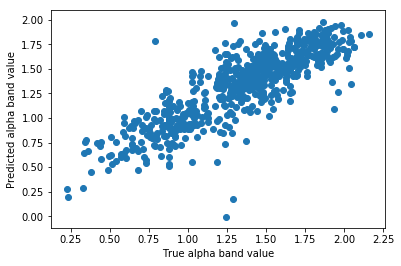

In [29]:
# Compare the true values with the predicted values. 
plt.scatter(y_te, y_pred_lr)
plt.xlabel('True alpha band value')
plt.ylabel('Predicted alpha band value');

In [30]:
# Compare the rank of the matrix X_tr with its shape. 
print('X_tr rank: ' + str(rank_lr))
print('X_tr shape: ' + str(X_tr.shape))

X_tr rank: 2442
X_tr shape: (2442, 29491)


In [31]:
# Display the shape of the coefficients from the regression model. 
coef_lr.shape

(29491,)

In [32]:
# Create a NumPy array, mapping the coefficients from the regression model to the 3D brain image. 
if rescaling_factor == 1:
    non_nan_indexes = non_nan_indexes_fMRI[subject_index]
elif rescaling_factor == 2:
    non_nan_indexes = non_nan_indexes_fMRI_r2[subject_index]
elif rescaling_factor == 3:
    non_nan_indexes = non_nan_indexes_fMRI_r3[subject_index]
coefficients_image_lr = create_coefficients_image(non_nan_indexes, coef_lr)

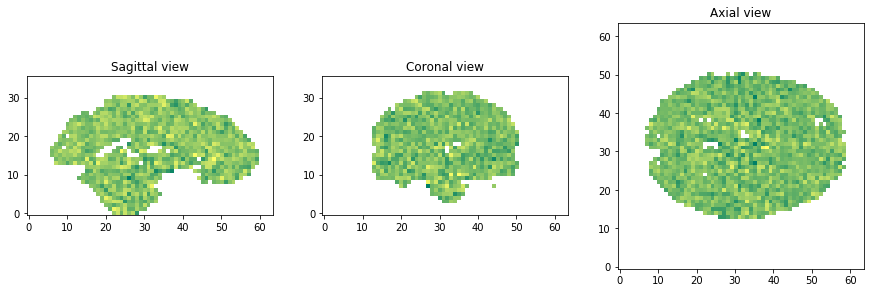

In [33]:
# Display the coefficient values for each voxel at the middle section coordinates. 
middle_coord = middle_sections(coefficients_image_lr)
display_fMRI_image(coefficients_image_lr[:, :, :, np.newaxis], middle_coord)

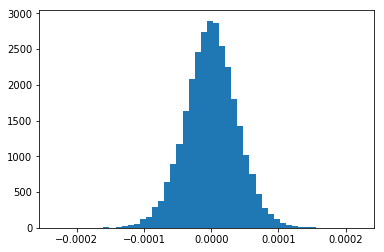

In [34]:
# Display the distribution of the coefficient values. 
plt.hist(coef_lr, bins = 50);

**Result:** The linear regression performs better than the baseline. The voxels associated with the highest coefficients do not seem to be located in a particular brain region. 

#### Regression with Huber loss

In [35]:
# Run a regression with Huber loss. 
y_pred_huber, mse_huber, mae_huber, rss_huber, r2_huber, coef_huber, _ = regression_model(
    HuberRegressor(epsilon = 1.35), X_tr, X_te, y_tr, y_te)

MSE: 0.057596233761448914
MAE: 0.18454335646885972
RSS: 35.19129882824529
R^2: 0.636237545521043


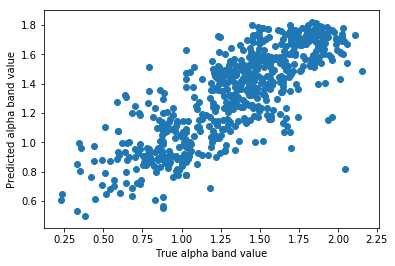

In [36]:
# Compare the true values with the predicted values. 
plt.scatter(y_te, y_pred_huber)
plt.xlabel('True alpha band value')
plt.ylabel('Predicted alpha band value');

In [37]:
# Create a NumPy array, mapping the coefficients from the regression model to the 3D brain image. 
if rescaling_factor == 1:
    non_nan_indexes = non_nan_indexes_fMRI[subject_index]
elif rescaling_factor == 2:
    non_nan_indexes = non_nan_indexes_fMRI_r2[subject_index]
elif rescaling_factor == 3:
    non_nan_indexes = non_nan_indexes_fMRI_r3[subject_index]
coefficients_image_huber = create_coefficients_image(non_nan_indexes, coef_huber)

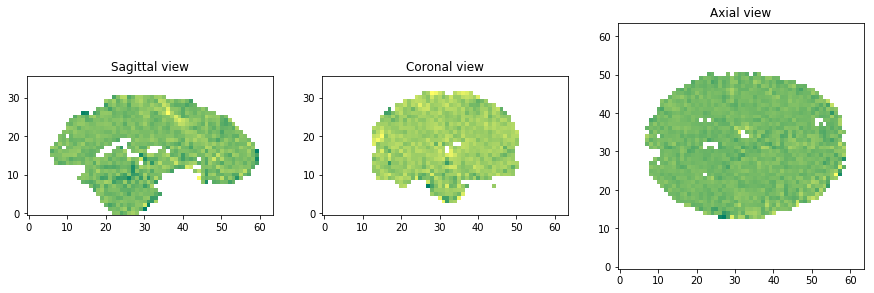

In [38]:
# Display the coefficient values for each voxel at the middle section coordinates. 
middle_coord = middle_sections(coefficients_image_huber)
display_fMRI_image(coefficients_image_huber[:, :, :, np.newaxis], middle_coord)

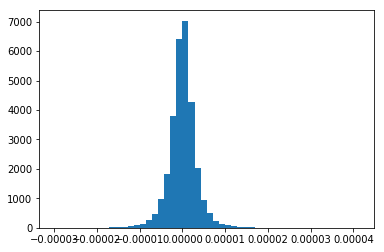

In [39]:
# Display the distribution of the coefficient values. 
plt.hist(coef_huber, bins = 50);

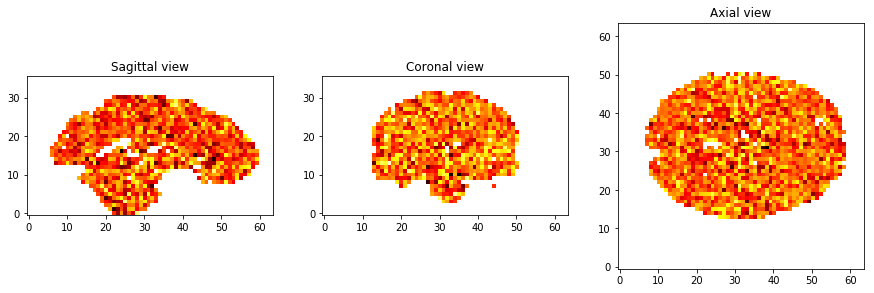

In [40]:
# Display the difference with the coefficients from the linear regression. 
display_fMRI_image(coefficients_image_huber[:, :, :, np.newaxis] - 
                   coefficients_image_lr[:, :, :, np.newaxis], middle_coord, colormap = 'hot')

**Result:** The regression with Huber loss performs better than the baseline. The voxels associated with the highest coefficients do not seem to be located in a particular brain region. No particular pattern seems visible when we compare the results with those of the linear regression model. 

#### Ridge regression

In [41]:
# Define the range of alpha values to explore for the Ridge regression. 
alpha_values = np.logspace(2, 10, num = 10)

In [42]:
# Fine-tune a Ridge regression. 
gs_results = fine_tune_ridge_or_lasso(Ridge, X_tr, X_te, y_tr, y_te, alpha_values)

Starting step 0 / 10
Starting step 1 / 10
Starting step 2 / 10
Starting step 3 / 10
Starting step 4 / 10
Starting step 5 / 10
Starting step 6 / 10
Starting step 7 / 10
Starting step 8 / 10
Starting step 9 / 10


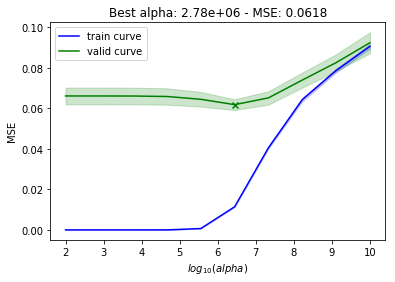

In [43]:
# Display fine-tuning results. 
best_alpha_ridge = display_ridge_or_lasso_fine_tuning(gs_results, alpha_values)

In [44]:
# Run a Ridge regression. 
y_pred_ridge, mse_ridge, mae_ridge, rss_ridge, r2_ridge, coef_ridge, _ = regression_model(
    Ridge(alpha = best_alpha_ridge), X_tr, X_te, y_tr, y_te)

MSE: 0.043994377677782436
MAE: 0.15833770719654872
RSS: 26.88056476112507
R^2: 0.7221432416288294


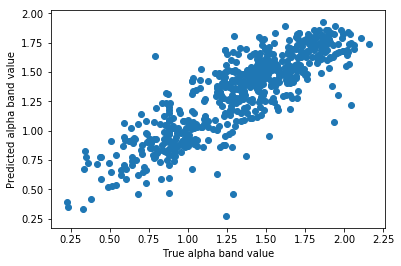

In [45]:
# Compare the true values with the predicted values. 
plt.scatter(y_te, y_pred_ridge)
plt.xlabel('True alpha band value')
plt.ylabel('Predicted alpha band value');

In [46]:
# Create a NumPy array, mapping the coefficients from the regression model to the 3D brain image. 
if rescaling_factor == 1:
    non_nan_indexes = non_nan_indexes_fMRI[subject_index]
elif rescaling_factor == 2:
    non_nan_indexes = non_nan_indexes_fMRI_r2[subject_index]
elif rescaling_factor == 3:
    non_nan_indexes = non_nan_indexes_fMRI_r3[subject_index]
coefficients_image_ridge = create_coefficients_image(non_nan_indexes, coef_ridge)

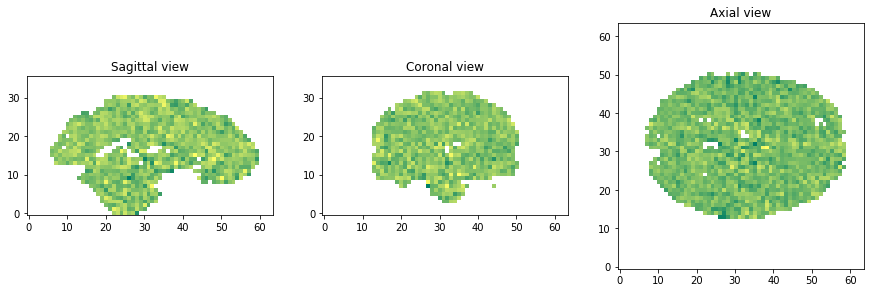

In [47]:
# Display the coefficient values for each voxel at the middle section coordinates. 
middle_coord = middle_sections(coefficients_image_ridge)
display_fMRI_image(coefficients_image_ridge[:, :, :, np.newaxis], middle_coord)

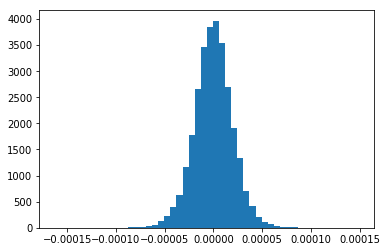

In [48]:
# Display the distribution of the coefficient values. 
plt.hist(coef_ridge, bins = 50);

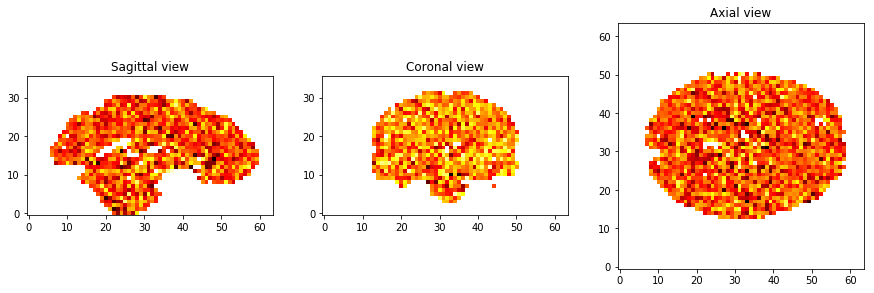

In [49]:
# Display the difference with the coefficients from the linear regression. 
display_fMRI_image(coefficients_image_ridge[:, :, :, np.newaxis] - 
                   coefficients_image_lr[:, :, :, np.newaxis], middle_coord, colormap = 'hot')

**Result:** The Ridge regression performs better than the baseline. The voxels associated with the highest coefficients do not seem to be located in a particular brain region. No particular pattern seems visible when we compare the results with those of the linear regression model. 

#### Lasso regression

In [50]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning

# Disable ConvergenceWarning error message. 
simplefilter("ignore", category = ConvergenceWarning)

In [51]:
# Define the range of alpha values to explore for the Lasso regression. 
alpha_values = np.logspace(-5, 1, num = 10)

In [52]:
# Fine-tune a Lasso regression. 
gs_results = fine_tune_ridge_or_lasso(Lasso, X_tr, X_te, y_tr, y_te, alpha_values)

Starting step 0 / 10
Starting step 1 / 10
Starting step 2 / 10
Starting step 3 / 10
Starting step 4 / 10
Starting step 5 / 10
Starting step 6 / 10
Starting step 7 / 10
Starting step 8 / 10
Starting step 9 / 10


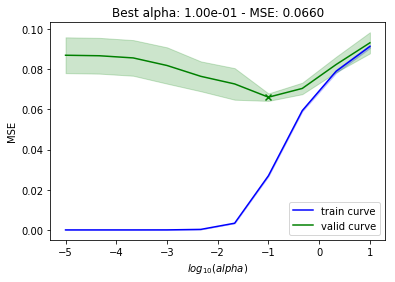

In [53]:
# Display fine-tuning results. 
best_alpha_lasso = display_ridge_or_lasso_fine_tuning(gs_results, alpha_values)

In [54]:
# Run a Lasso regression. 
y_pred_lasso, mse_lasso, mae_lasso, rss_lasso, r2_lasso, coef_lasso, _ = regression_model(
    Lasso(alpha = best_alpha_lasso), X_tr, X_te, y_tr, y_te)

MSE: 0.05108006890138435
MAE: 0.16959399589268054
RSS: 31.20992209874584
R^2: 0.677391905250605


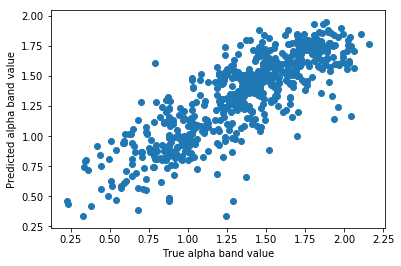

In [55]:
# Compare the true values with the predicted values. 
plt.scatter(y_te, y_pred_lasso)
plt.xlabel('True alpha band value')
plt.ylabel('Predicted alpha band value');

In [56]:
# Create a NumPy array, mapping the coefficients from the regression model to the 3D brain image. 
if rescaling_factor == 1:
    non_nan_indexes = non_nan_indexes_fMRI[subject_index]
elif rescaling_factor == 2:
    non_nan_indexes = non_nan_indexes_fMRI_r2[subject_index]
elif rescaling_factor == 3:
    non_nan_indexes = non_nan_indexes_fMRI_r3[subject_index]
coefficients_image_lasso = create_coefficients_image(non_nan_indexes, coef_lasso)

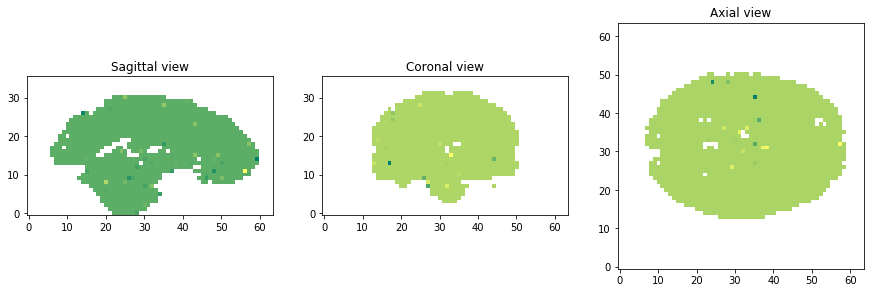

In [57]:
# Display the coefficient values for each voxel at the middle section coordinates. 
middle_coord = middle_sections(coefficients_image_lasso)
display_fMRI_image(coefficients_image_lasso[:, :, :, np.newaxis], middle_coord)

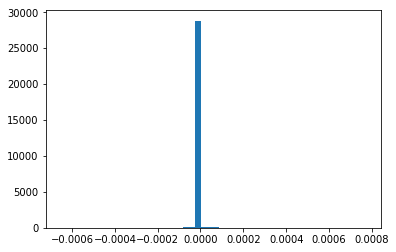

In [58]:
# Display the distribution of the coefficient values. 
plt.hist(coef_lasso, bins = 50);

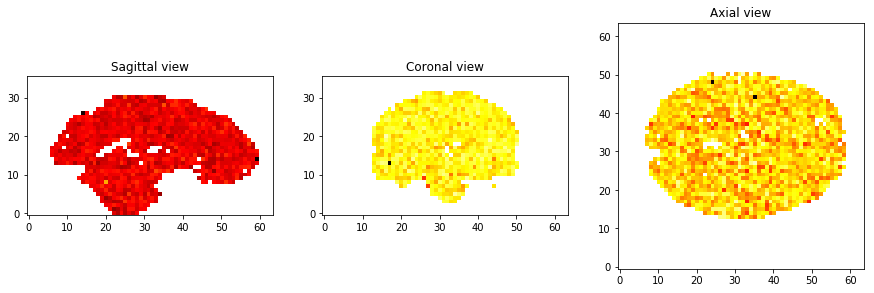

In [59]:
# Display the difference with the coefficients from the linear regression. 
display_fMRI_image(coefficients_image_lasso[:, :, :, np.newaxis] - 
                   coefficients_image_lr[:, :, :, np.newaxis], middle_coord, colormap = 'hot')

In [60]:
# Display the number non-zero coefficients, and the total number of coefficients, obtained from the Lasso regression. 
print('Non-zero coefficients: ' + str(coef_lasso[coef_lasso != 0].shape[0]))
print('Total number of coefficients: ' + str(coef_lasso.shape[0]))
print('Proportion of non-zero coefficients: ' + str(np.round(coef_lasso[coef_lasso != 0].shape[0] / coef_lasso.shape[0], 4)))

Non-zero coefficients: 757
Total number of coefficients: 29491
Proportion of non-zero coefficients: 0.0257


In [61]:
# Find the coordinates of the voxel with the highest coefficient. 
highest_coefficient_voxel = np.unravel_index(np.nanargmax(coefficients_image_lasso), coefficients_image_lasso.shape)
highest_coefficient_voxel

(37, 47, 26)

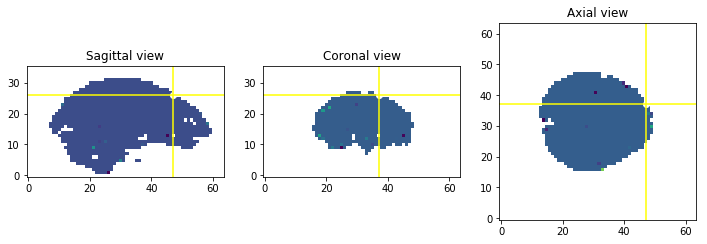

In [62]:
# Display the position of the voxel with the highest coefficient. 
display_voxel_or_cluster_position(highest_coefficient_voxel, coefficients_image_lasso, coefficients_image_lasso.shape)

**Result:** The Lasso regression performs better than the baseline. Most of the coefficients are shrunk to zero, and the remaining voxels do not seem to be located in a particular brain region. Nevertheless, and while the results can vary at each run due to the stochastic nature of the train/test split, most of the time **the voxel with the highest coefficient is located in a cortical area**. Indeed, since the EEG signal is produced by specific layers in the cortex, we expect that some of the most informative voxels should be in cortical areas. 

In [63]:
# Save the results into a .npz file. 
np.savez(results_path + 'regression_with_fMRI_predictors_single_subject.npz', 
         
         # Example subject. 
         subject_index = subject_index,
         
         # Baseline. 
         rss_baseline = rss_baseline,
         
         # Linear regression. 
         rss_lr = rss_lr, 
         r2_lr = r2_lr, 
         coef_lr = coef_lr, 
         coefficients_image_lr = coefficients_image_lr, 
         
         # Regression with Huber loss. 
         rss_huber = rss_huber, 
         r2_huber = r2_huber, 
         coef_huber = coef_huber,
         coefficients_image_huber = coefficients_image_huber, 
         
         # Ridge regression. 
         rss_ridge = rss_ridge, 
         r2_ridge = r2_ridge, 
         coef_ridge = coef_ridge, 
         coefficients_image_ridge = coefficients_image_ridge, 
         
         # Lasso regression. 
         rss_lasso = rss_lasso, 
         r2_lasso = r2_lasso, 
         coef_lasso = coef_lasso, 
         coefficients_image_lasso = coefficients_image_lasso)

### **3.2 Targets: all the EEG frequency bands**

In the following cells, we **fit and compute predictions from a linear regression** for a single subject, using successively all the EEG frequency bands as targets. 

In [64]:
# Define an example subject. 
subject_index = subjects[1] # Warning: the first subject has inconsistent length of EEG and fMRI data. 

# Define the voxel size rescaling factor to be used. 1: original voxel size. 2: factor 2. 3: factor 3. 
rescaling_factor = 1

In [65]:
# Define the indexes of the EEG frequency bands. 
target_bands = range(2, 8)

# Check the names of the EEG frequency bands associated with these indexes. 
target_bands_names = predictors_EEG[subject_index].columns[target_bands].values
target_bands_names

array(['SW', 'delta', 'theta', 'alpha', 'sigma', 'beta'], dtype=object)

In [66]:
# Create a dictionary to store the results. 
lr_all_bands_results = dict()

# Iterate through all target bands. 
for target_band_index in target_bands:
    
    # Display current step. 
    print('Starting target band: ' + predictors_EEG[subject_index].columns[target_band_index])
    
    # Define the features and target variables. 
    if rescaling_factor == 1:
        X = formatted_predictors_fMRI[subject_index]
    elif rescaling_factor == 2:
        X = formatted_predictors_fMRI_r2[subject_index]
    elif rescaling_factor == 3:
        X = formatted_predictors_fMRI_r3[subject_index]
    y = predictors_EEG[subject_index].iloc[:, target_band_index].values
    
    # Divide the data into a train set and a test set. 
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size = test_set_proportion)
    
    # Baseline model: mean value of the alpha band in the train set. 
    rss_baseline = RSS(y_te, np.mean(y_tr))
    
    # Run a linear regression. 
    y_pred_lr, mse_lr, mae_lr, rss_lr, r2_lr, coef_lr, rank_lr = regression_model(
        LinearRegression(), X_tr, X_te, y_tr, y_te, return_rank = True)
    print()
    
    # Create a NumPy array, mapping the coefficients from the regression model to the 3D brain image. 
    if rescaling_factor == 1:
        non_nan_indexes = non_nan_indexes_fMRI[subject_index]
    elif rescaling_factor == 2:
        non_nan_indexes = non_nan_indexes_fMRI_r2[subject_index]
    elif rescaling_factor == 3:
        non_nan_indexes = non_nan_indexes_fMRI_r3[subject_index]
    coefficients_image_lr = create_coefficients_image(non_nan_indexes, coef_lr)
    middle_coord = middle_sections(coefficients_image_lr)
    
    # Store the results in the dictionary. 
    lr_all_bands_results[target_band_index] = {'y_te': y_te, 
                                               'y_pred_lr': y_pred_lr,
                                               'coef_lr': coef_lr,
                                               'coefficients_image_lr': coefficients_image_lr,
                                               'middle_coord': middle_coord,
                                               'rss_baseline': rss_baseline,
                                               'rss_lr': rss_lr,
                                               'r2_lr': r2_lr}

Starting target band: SW
MSE: 0.155407098272288
MAE: 0.28113093483257023
RSS: 94.95373704436795
R^2: 0.8848646751219245

Starting target band: delta
MSE: 0.10942239034290302
MAE: 0.2540980476219792
RSS: 66.85708049951374
R^2: 0.8814059116105794

Starting target band: theta
MSE: 0.06190084706365333
MAE: 0.1851321595089896
RSS: 37.82141755589218
R^2: 0.7661116423617733

Starting target band: alpha
MSE: 0.06610505771638167
MAE: 0.17720012295192264
RSS: 40.390190264709204
R^2: 0.5904831073530026

Starting target band: sigma
MSE: 0.061393167295296286
MAE: 0.18531815002232402
RSS: 37.51122521742603
R^2: 0.7278992051008588

Starting target band: beta
MSE: 0.038614179315232804
MAE: 0.14639810895361782
RSS: 23.593263561607245
R^2: 0.6795089220233872



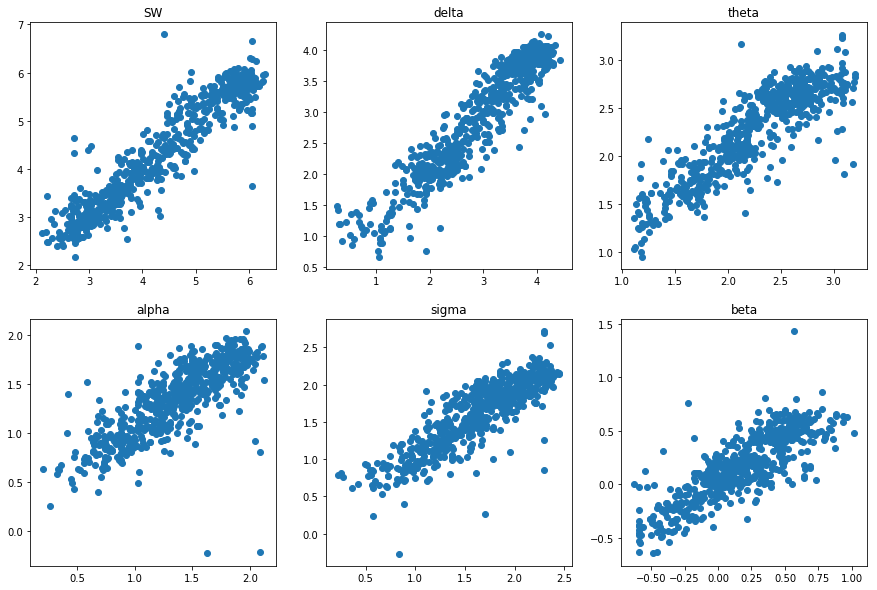

In [67]:
# Compare the true values with the predicted values, for all EEG frequency bands. 
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (15, 10))
axes[0, 0].scatter(lr_all_bands_results[2]['y_te'], lr_all_bands_results[2]['y_pred_lr'])
axes[0, 0].set_title('SW')
axes[0, 1].scatter(lr_all_bands_results[3]['y_te'], lr_all_bands_results[3]['y_pred_lr'])
axes[0, 1].set_title('delta')
axes[0, 2].scatter(lr_all_bands_results[4]['y_te'], lr_all_bands_results[4]['y_pred_lr'])
axes[0, 2].set_title('theta')
axes[1, 0].scatter(lr_all_bands_results[5]['y_te'], lr_all_bands_results[5]['y_pred_lr'])
axes[1, 0].set_title('alpha')
axes[1, 1].scatter(lr_all_bands_results[6]['y_te'], lr_all_bands_results[6]['y_pred_lr'])
axes[1, 1].set_title('sigma')
axes[1, 2].scatter(lr_all_bands_results[7]['y_te'], lr_all_bands_results[7]['y_pred_lr'])
axes[1, 2].set_title('beta');

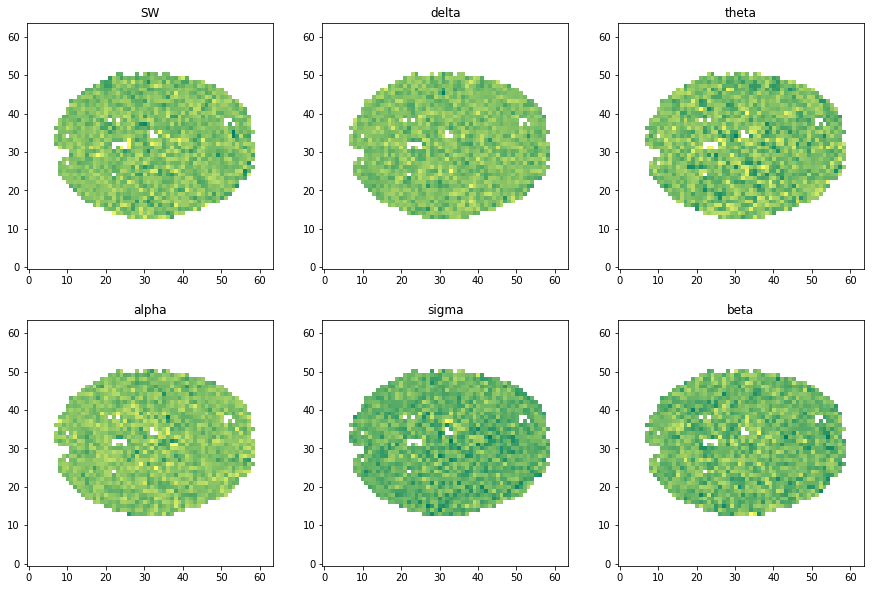

In [68]:
# Display the coefficient values for each voxel at the middle section of the axial view, for all EEG frequency bands. 
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (15, 10))
middle_coord = lr_all_bands_results[2]['middle_coord']
axes[0, 0].imshow(lr_all_bands_results[2]['coefficients_image_lr'][:, :, middle_coord[2]], origin = 'lower', cmap = 'summer')
axes[0, 0].set_title('SW')
axes[0, 1].imshow(lr_all_bands_results[3]['coefficients_image_lr'][:, :, middle_coord[2]], origin = 'lower', cmap = 'summer')
axes[0, 1].set_title('delta')
axes[0, 2].imshow(lr_all_bands_results[4]['coefficients_image_lr'][:, :, middle_coord[2]], origin = 'lower', cmap = 'summer')
axes[0, 2].set_title('theta')
axes[1, 0].imshow(lr_all_bands_results[5]['coefficients_image_lr'][:, :, middle_coord[2]], origin = 'lower', cmap = 'summer')
axes[1, 0].set_title('alpha')
axes[1, 1].imshow(lr_all_bands_results[6]['coefficients_image_lr'][:, :, middle_coord[2]], origin = 'lower', cmap = 'summer')
axes[1, 1].set_title('sigma')
axes[1, 2].imshow(lr_all_bands_results[7]['coefficients_image_lr'][:, :, middle_coord[2]], origin = 'lower', cmap = 'summer')
axes[1, 2].set_title('beta');

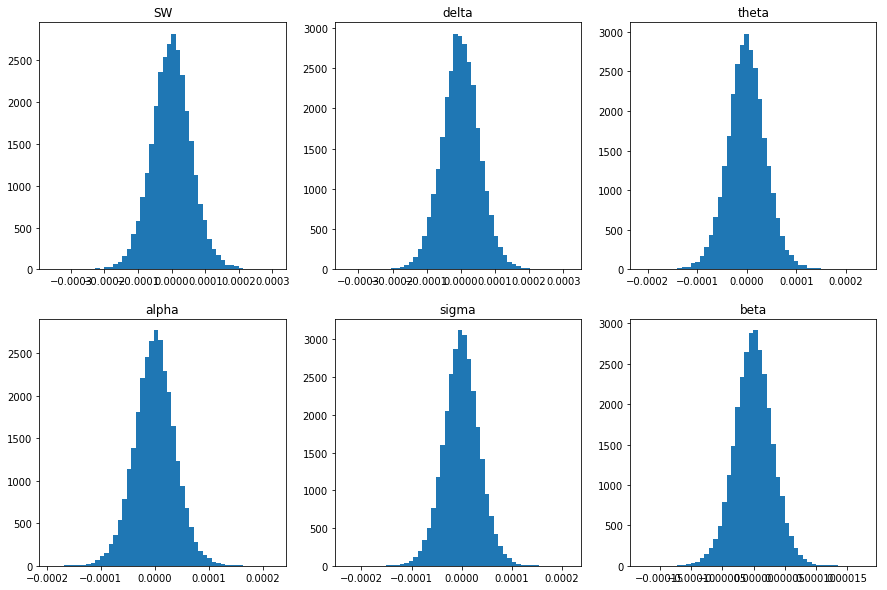

In [69]:
# Display the distribution of the coefficient values, for all EEG frequency bands. 
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (15, 10))
axes[0, 0].hist(lr_all_bands_results[2]['coef_lr'], bins = 50)
axes[0, 0].set_title('SW')
axes[0, 1].hist(lr_all_bands_results[3]['coef_lr'], bins = 50)
axes[0, 1].set_title('delta')
axes[0, 2].hist(lr_all_bands_results[4]['coef_lr'], bins = 50)
axes[0, 2].set_title('theta')
axes[1, 0].hist(lr_all_bands_results[5]['coef_lr'], bins = 50)
axes[1, 0].set_title('alpha')
axes[1, 1].hist(lr_all_bands_results[6]['coef_lr'], bins = 50)
axes[1, 1].set_title('sigma')
axes[1, 2].hist(lr_all_bands_results[7]['coef_lr'], bins = 50)
axes[1, 2].set_title('beta');

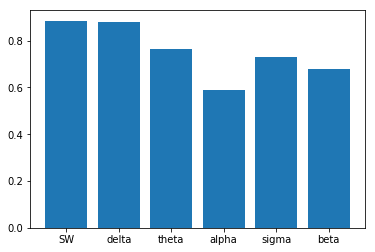

In [70]:
# Display the R^2 measure for all EEG frequency bands. 
r2_lr_all_bands = []
for target_band_index in range(2, 8):
    r2_lr_all_bands.append(lr_all_bands_results[target_band_index]['r2_lr'])
plt.bar(range(2, 8), r2_lr_all_bands, tick_label = target_bands_names);

**Result:** The linear regression performs better than the baseline for all the EEG frequency bands. In none of these bands do the voxels associated with the highest coefficients seem to be located in a particular brain region. 

## **4. Regression on all subjects**

### **4.1 Target: the alpha band**

In the following cells, we **fit and compute predictions from a linear regression** for all the subjects, using the alpha band as the target. 

In [71]:
# Define the voxel size rescaling factor to be used. 1: original voxel size. 2: factor 2. 3: factor 3. 
rescaling_factor = 3

In [72]:
# Define the alpha band as our EEG frequency band of interest. 
target_band_index = 5

# Check that the index corresponds to the alpha band. 
predictors_EEG[subject_index].columns[target_band_index]

'alpha'

In [73]:
# Create a dictionary to store the results. 
lr_all_subjects_results = dict()

# Iterate through all subjects. 
for subject_index in subjects[1:]: # Warning: the first subject has inconsistent length of EEG and fMRI data. 
    
    # Display current step. 
    print('Starting subject: ' + subject_index)
    
    # Define the features and target variables. 
    if rescaling_factor == 1:
        X = formatted_predictors_fMRI[subject_index]
    elif rescaling_factor == 2:
        X = formatted_predictors_fMRI_r2[subject_index]
    elif rescaling_factor == 3:
        X = formatted_predictors_fMRI_r3[subject_index]
    y = predictors_EEG[subject_index].iloc[:, target_band_index].values
    
    # Divide the data into a train set and a test set. 
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size = test_set_proportion)
    
    # Baseline model: mean value of the alpha band in the train set. 
    rss_baseline = RSS(y_te, np.mean(y_tr))
    
    # Run a linear regression. 
    y_pred_lr, mse_lr, mae_lr, rss_lr, r2_lr, coef_lr, rank_lr = regression_model(
        LinearRegression(), X_tr, X_te, y_tr, y_te, return_rank = True)
    print()
    
    # Create a NumPy array, mapping the coefficients from the regression model to the 3D brain image. 
    if rescaling_factor == 1:
        non_nan_indexes = non_nan_indexes_fMRI[subject_index]
    elif rescaling_factor == 2:
        non_nan_indexes = non_nan_indexes_fMRI_r2[subject_index]
    elif rescaling_factor == 3:
        non_nan_indexes = non_nan_indexes_fMRI_r3[subject_index]
    coefficients_image_lr = create_coefficients_image(non_nan_indexes, coef_lr)
    middle_coord = middle_sections(coefficients_image_lr)
    
    # Store the results in the dictionary. 
    lr_all_subjects_results[subject_index] = {'y_te': y_te, 
                                              'y_pred_lr': y_pred_lr,
                                              'coef_lr': coef_lr,
                                              'coefficients_image_lr': coefficients_image_lr,
                                              'middle_coord': middle_coord,
                                              'rss_baseline': rss_baseline,
                                              'rss_lr': rss_lr,
                                              'r2_lr': r2_lr}

Starting subject: sub-02
MSE: 0.08055149151505998
MAE: 0.2209934009969511
RSS: 49.21696131570165
R^2: 0.5420064778692907

Starting subject: sub-03
MSE: 0.07165450269156187
MAE: 0.21232232720435606
RSS: 37.26034139961217
R^2: 0.28961047008196583

Starting subject: sub-04
MSE: 0.11336645782280964
MAE: 0.2700753756203035
RSS: 53.28223517672053
R^2: 0.5964277768257422

Starting subject: sub-05
MSE: 0.0808418975367579
MAE: 0.20928637012476936
RSS: 58.044482431392176
R^2: -0.16316493705994795

Starting subject: sub-06
MSE: 0.12978876896574393
MAE: 0.28274810547611273
RSS: 78.39241645530933
R^2: 0.25112943636852525

Starting subject: sub-07
MSE: 0.07202938088323949
MAE: 0.2123742821578692
RSS: 37.95948372546721
R^2: 0.47352930854644537

Starting subject: sub-08
MSE: 0.07646494747619517
MAE: 0.21922684223034372
RSS: 49.54928596457447
R^2: 0.42221693744845956

Starting subject: sub-09
MSE: 0.11266049712995692
MAE: 0.2675901893863102
RSS: 55.31630409080885
R^2: -0.008504514642004857

Starting su

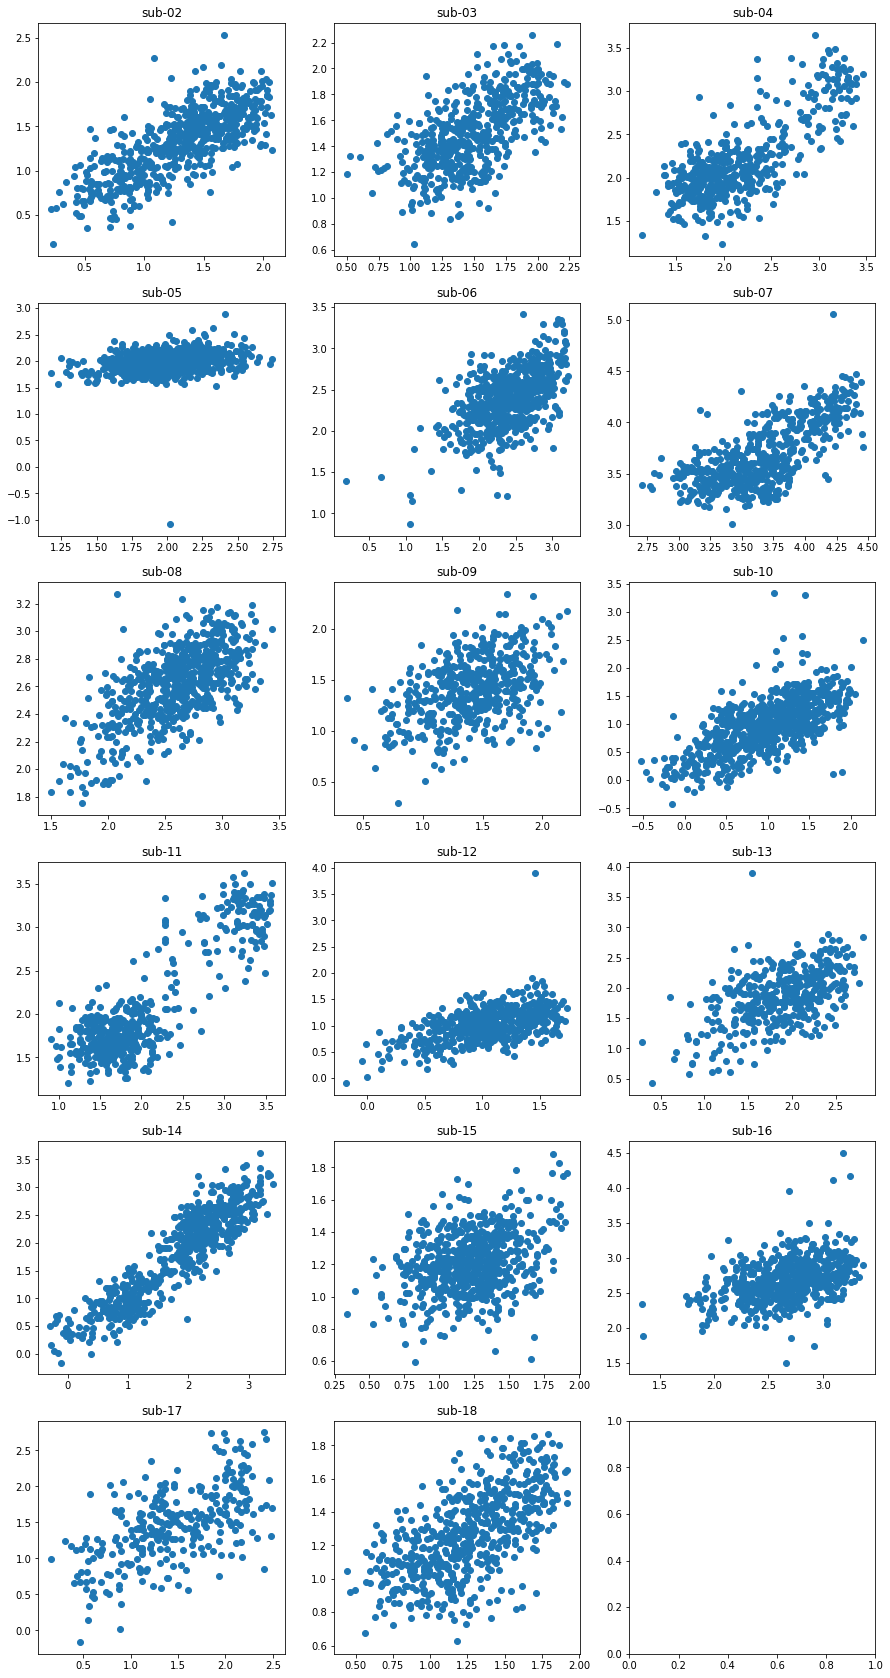

In [74]:
# Compare the true values with the predicted values, for all subjects. 
fig, axes = plt.subplots(nrows = 6, ncols = 3, figsize = (15, 30))
counter = 0

# Iterate through all subjects. 
for subject_index in subjects[1:]: # Warning: the first subject has inconsistent length of EEG and fMRI data. 
    
    # Compute the row and column indexes. 
    row_index = counter // 3
    column_index = counter % 3
    
    # Draw the graphs. 
    axes[row_index, column_index].scatter(lr_all_subjects_results[subject_index]['y_te'], lr_all_subjects_results[subject_index]['y_pred_lr'])
    axes[row_index, column_index].set_title(subject_index);
    
    # Increment. 
    counter += 1

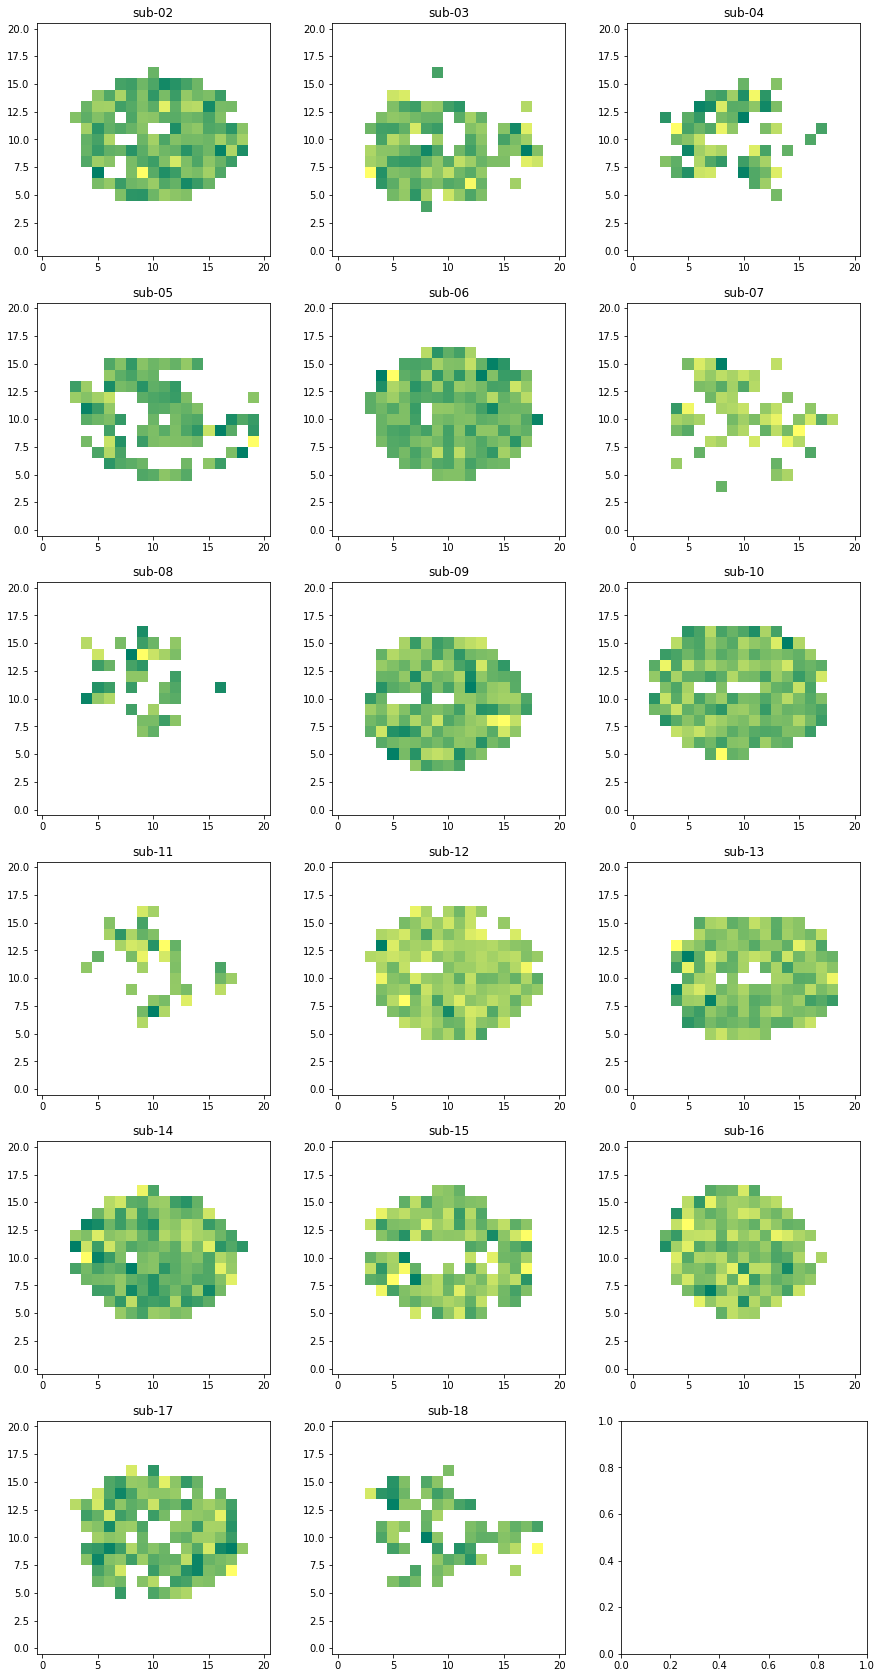

In [75]:
# Display the coefficient values for each voxel at the middle section of the axial view, for all subjects. 
fig, axes = plt.subplots(nrows = 6, ncols = 3, figsize = (15, 30))
counter = 0

# Iterate through all subjects. 
for subject_index in subjects[1:]: # Warning: the first subject has inconsistent length of EEG and fMRI data. 
    
    # Compute the row and column indexes. 
    row_index = counter // 3
    column_index = counter % 3
    
    # Draw the graphs. 
    middle_coord = lr_all_subjects_results[subject_index]['middle_coord']
    axes[row_index, column_index].imshow(lr_all_subjects_results[subject_index]['coefficients_image_lr'][:, :, middle_coord[2]], origin = 'lower', cmap = 'summer')
    axes[row_index, column_index].set_title(subject_index)
    
    # Increment. 
    counter += 1

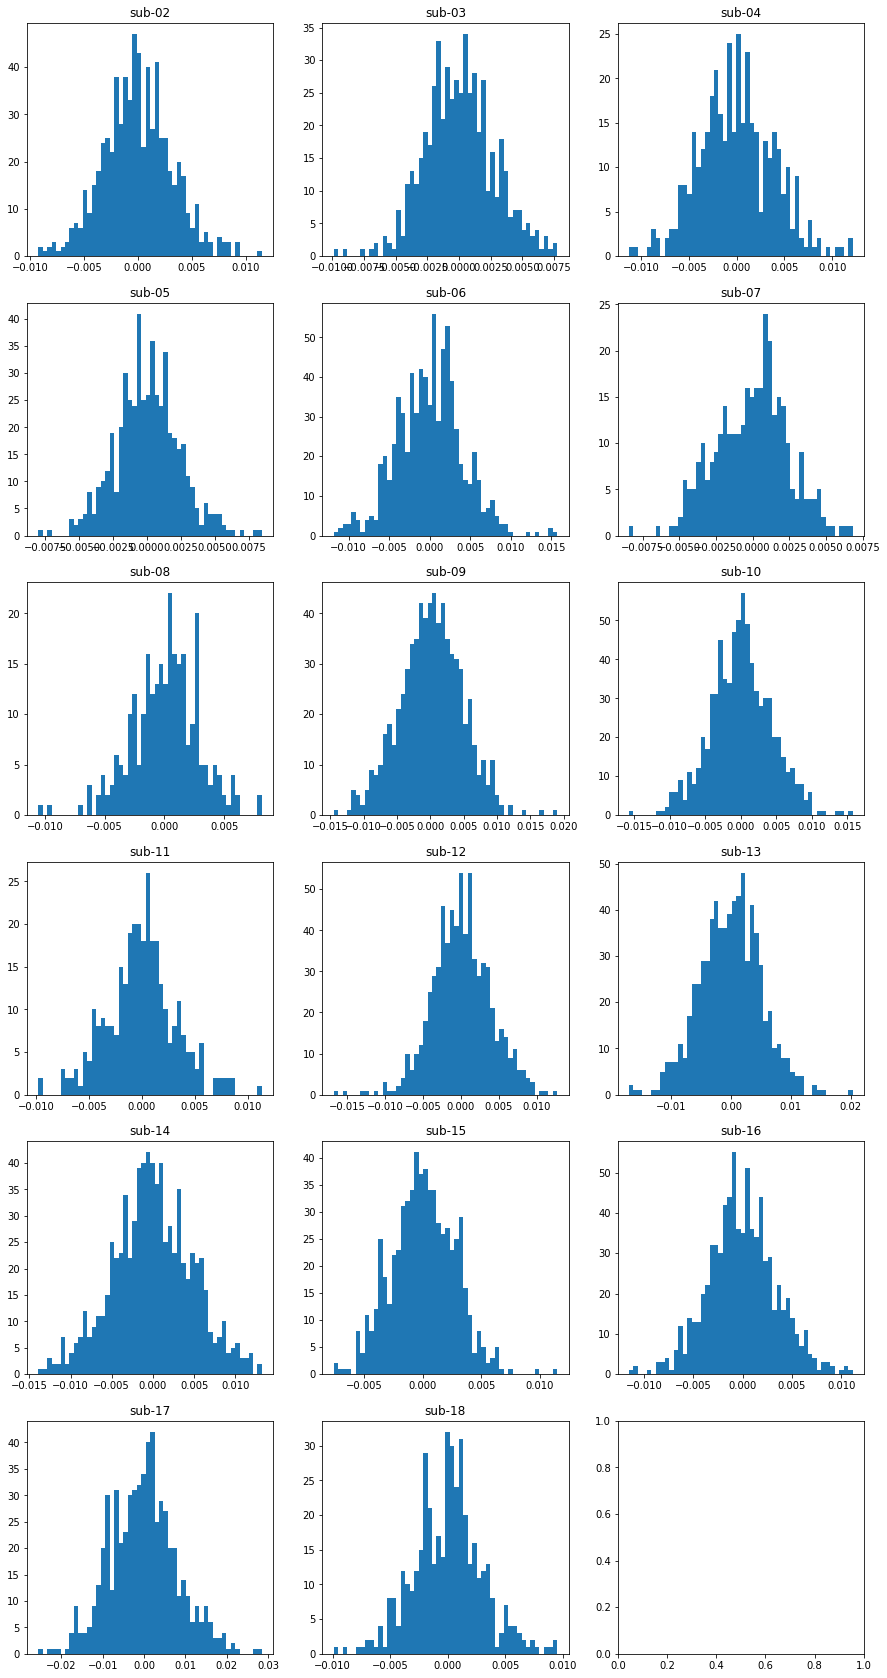

In [76]:
# Display the distribution of the coefficient values, for all subjects. 
fig, axes = plt.subplots(nrows = 6, ncols = 3, figsize = (15, 30))
counter = 0

# Iterate through all subjects. 
for subject_index in subjects[1:]: # Warning: the first subject has inconsistent length of EEG and fMRI data. 
    
    # Compute the row and column indexes. 
    row_index = counter // 3
    column_index = counter % 3
    
    # Draw the graphs.     
    axes[row_index, column_index].hist(lr_all_subjects_results[subject_index]['coef_lr'], bins = 50)
    axes[row_index, column_index].set_title(subject_index);
    
    # Increment. 
    counter += 1

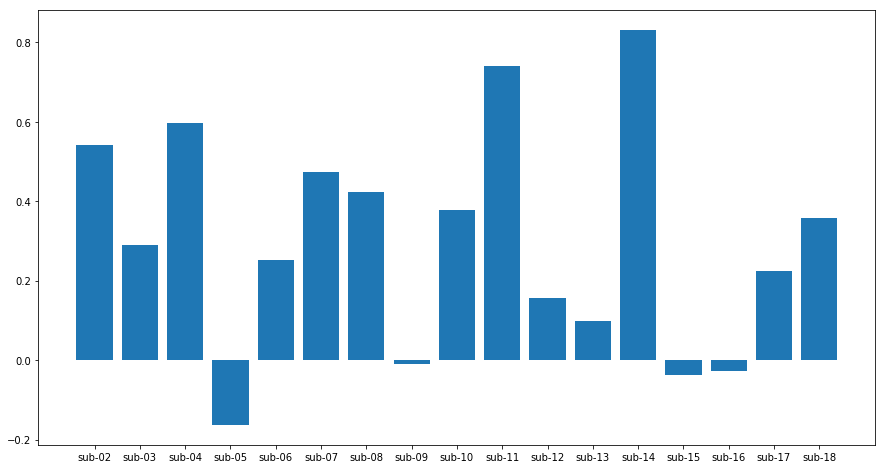

In [77]:
# Display the R^2 measure for all subjects. 
r2_lr_all_subjects = []
for subject_index in subjects[1:]: # Warning: the first subject has inconsistent length of EEG and fMRI data. 
    r2_lr_all_subjects.append(lr_all_subjects_results[subject_index]['r2_lr'])
plt.figure(figsize = (15, 8))
plt.bar(range(2, 19), r2_lr_all_subjects, tick_label = subjects[1:]);

**Result:** The linear regression performs better than the baseline for most of the subjects. Nevertheless, the R^2 measure is very variable, with a high predictability in some subjects, and a low or even negative predictability in others. We must remember that we are using the fMRI dataset with a voxel size rescaling by a factor 3, and not the dataset with the original voxel size as we did in the previous section for a single subject. 

### **4.2 Targets: all the EEG frequency bands**

In the following cells, we **fit and compute predictions from a linear regression** for all the subjects and all the EEG frequency bands. 

In [78]:
# Create a dictionary to store the results at the subject level. 
lr_results_at_subject_level = dict()

# Iterate through all subjects. 
for subject_index in subjects[1:]: # Warning: the first subject has inconsistent length of EEG and fMRI data. 
    
    # Display current step. 
    print('Starting subject: ' + subject_index)
    
    # Create a dictionary to store the results at the target band level. 
    lr_results_at_target_band_level = dict()
    
    # Iterate through all target bands. 
    for target_band_index in target_bands:
    
        # Define the features and target variables. 
        if rescaling_factor == 1:
            X = formatted_predictors_fMRI[subject_index]
        elif rescaling_factor == 2:
            X = formatted_predictors_fMRI_r2[subject_index]
        elif rescaling_factor == 3:
            X = formatted_predictors_fMRI_r3[subject_index]
        y = predictors_EEG[subject_index].iloc[:, target_band_index].values

        # Divide the data into a train set and a test set. 
        X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size = test_set_proportion)

        # Baseline model: mean value of the alpha band in the train set. 
        rss_baseline = RSS(y_te, np.mean(y_tr))

        # Run a linear regression. 
        y_pred_lr, mse_lr, mae_lr, rss_lr, r2_lr, coef_lr, rank_lr = regression_model(
            LinearRegression(), X_tr, X_te, y_tr, y_te, display_results = False, return_rank = True)

        # Create a NumPy array, mapping the coefficients from the regression model to the 3D brain image. 
        if rescaling_factor == 1:
            non_nan_indexes = non_nan_indexes_fMRI[subject_index]
        elif rescaling_factor == 2:
            non_nan_indexes = non_nan_indexes_fMRI_r2[subject_index]
        elif rescaling_factor == 3:
            non_nan_indexes = non_nan_indexes_fMRI_r3[subject_index]
        coefficients_image_lr = create_coefficients_image(non_nan_indexes, coef_lr)
        middle_coord = middle_sections(coefficients_image_lr)

        # Store the results in the dictionary. 
        lr_results_at_target_band_level[target_band_index] = {'y_te': y_te, 
                                                              'y_pred_lr': y_pred_lr,
                                                              'coef_lr': coef_lr,
                                                              'coefficients_image_lr': coefficients_image_lr,
                                                              'middle_coord': middle_coord,
                                                              'rss_baseline': rss_baseline,
                                                              'rss_lr': rss_lr,
                                                              'r2_lr': r2_lr}
    # Store the results in the dictionary. 
    lr_results_at_subject_level[subject_index] = lr_results_at_target_band_level

Starting subject: sub-02
Starting subject: sub-03
Starting subject: sub-04
Starting subject: sub-05
Starting subject: sub-06
Starting subject: sub-07
Starting subject: sub-08
Starting subject: sub-09
Starting subject: sub-10
Starting subject: sub-11
Starting subject: sub-12
Starting subject: sub-13
Starting subject: sub-14
Starting subject: sub-15
Starting subject: sub-16
Starting subject: sub-17
Starting subject: sub-18


In [79]:
# Define a function to display the R^2 value for all subjects, for a certain target band. 
def plot_r2_for_all_subjects(target_band_index):
    color_names = ['purple', 'blue', 'green', 'gold', 'orange', 'red']
    r2_lr_all_subjects = []
    for subject_index in subjects[1:]: # Warning: the first subject has inconsistent length of EEG and fMRI data. 
        r2_lr_all_subjects.append(lr_results_at_subject_level[subject_index][target_band_index]['r2_lr'])
    plt.figure(figsize = (15, 8))
    plt.bar(range(2, 19), r2_lr_all_subjects, tick_label = subjects[1:], color = color_names[target_band_index - 2])
    plt.title(target_bands_names[target_band_index - 2]);

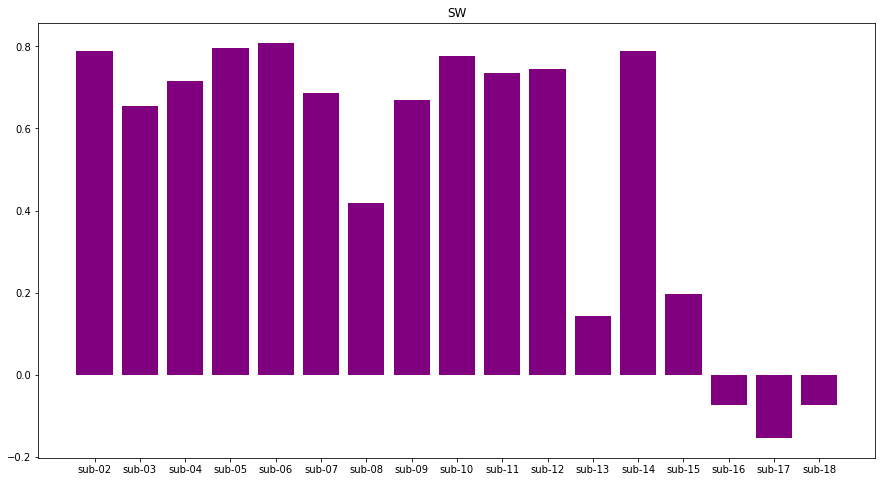

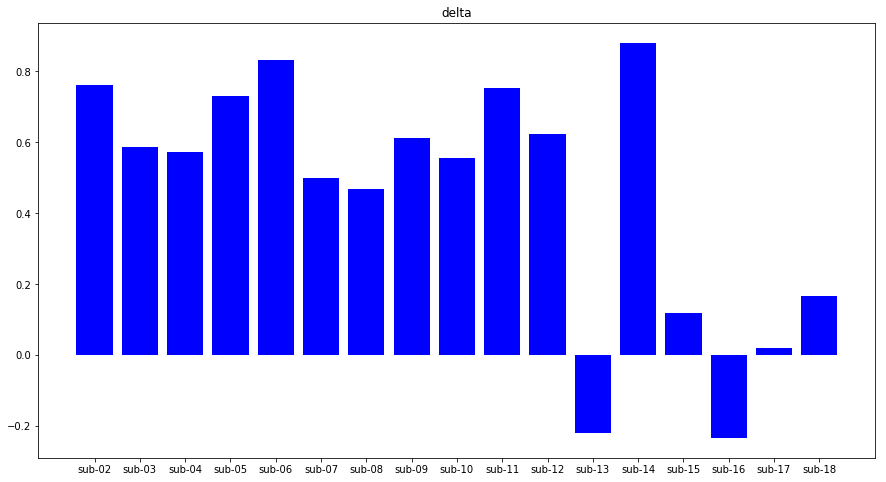

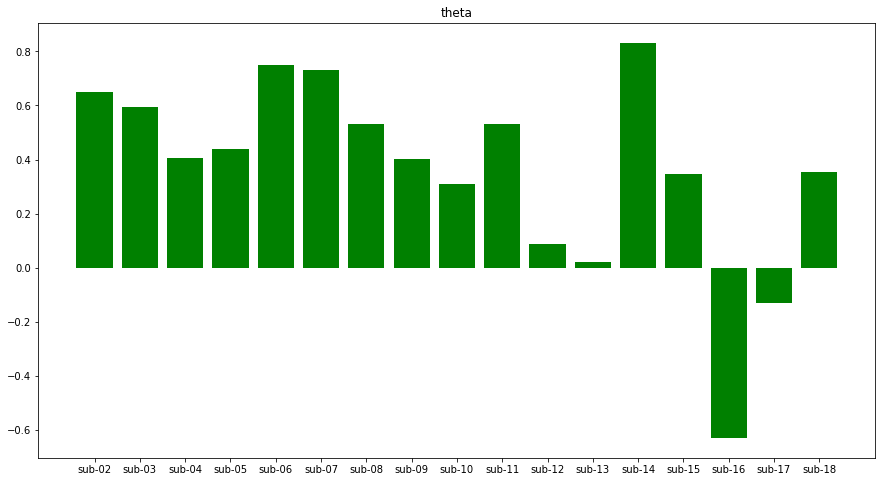

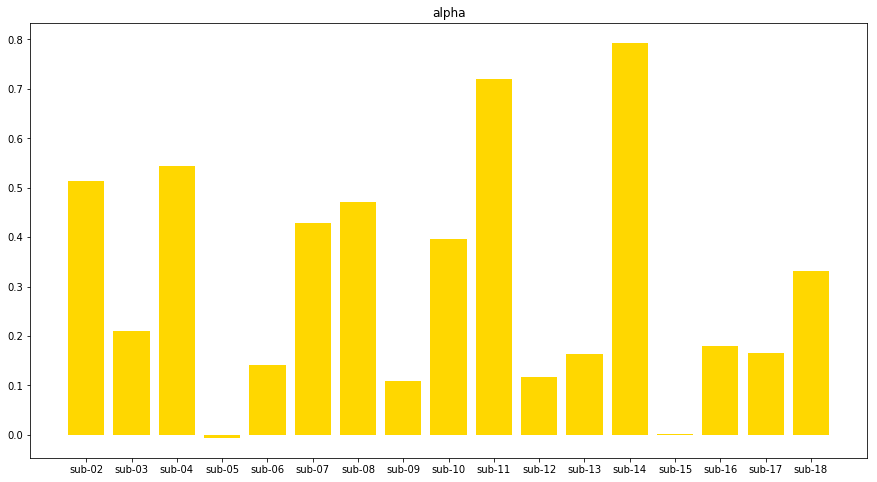

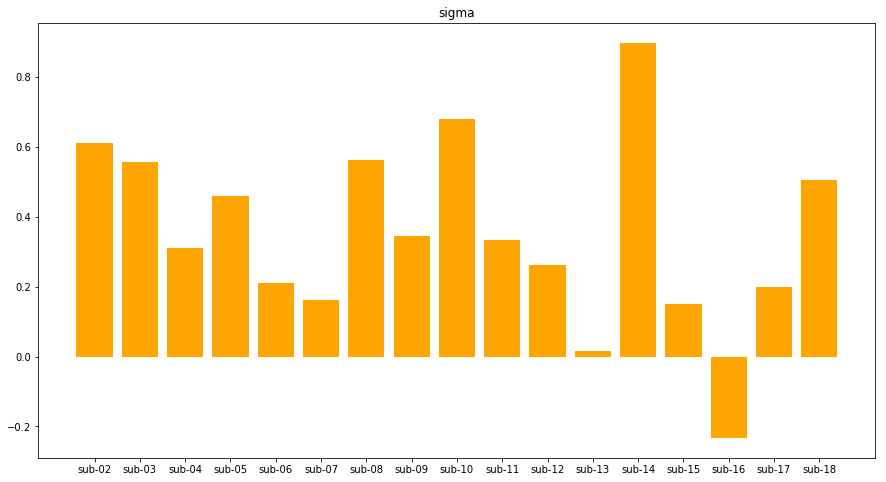

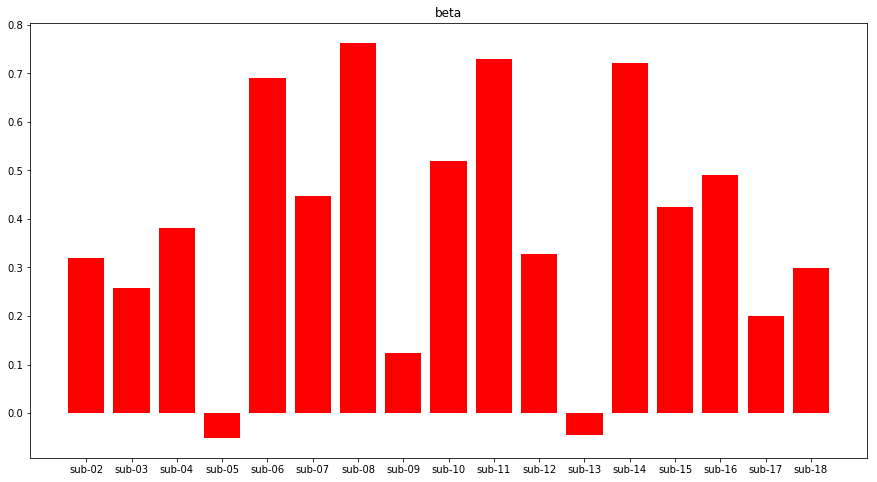

In [80]:
# Display the R^2 value for all subjects and all EEG frequency bands. 
for target_band_index in range(2, 8):
    plot_r2_for_all_subjects(target_band_index)

**Result:** The linear regression performs better than the baseline for most of the subjects and EEG frequency bands. Nevertheless, the R^2 measure is very variable, with a high predictability in some cases, and a low or even negative predictability in others. Again, we must remember that we are using the fMRI dataset with a voxel size rescaling by a factor 3, and not the dataset with the original voxel size as we did in the previous section for a single subject. 

In [81]:
# Save the results into a Pickle file. 
with open(results_path + 'regression_with_fMRI_predictors.p', 'wb') as file:
    pickle.dump(lr_results_at_subject_level, file)